In [228]:
%load_ext autoreload
%autoreload 2

In [229]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import networkx as nx

# JAX
import jax
import jax.numpy as jnp
import jraph
import numpy as np
import haiku as hk
import optax

# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

from model import VGAE

In [158]:
rng_key = jax.random.PRNGKey(42)

In [51]:
def plot_samps(draws, columns=4, rows=3, figsize = (19,12), ttl="CAR priors"):
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    _min, _max = np.amin(draws[0:columns*rows]), np.amax(draws[0:columns*rows])
    for r in range(rows):
        for c in range(columns):
            im = axs[r, c].imshow(draws[r*columns + c].reshape(num_y, num_x), 
                                  cmap='viridis', interpolation='none', #extent=[0,1,0,1], 
                                  origin='lower')
                                  #,vmin=_min, vmax=_max)
            axs[r, c].set_title("draw "+str(r*columns + c))  
            fig.colorbar(im, ax=axs[r, c])
    fig.suptitle(ttl, fontsize=16)
    plt.show()
    
def plot_truth_estimate(y_true, mean_post_pred_vae, ttl1="Ground truth", ttl2="CAR estimate"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    _min, _max = np.amin([y_true, mean_post_pred_vae]), np.amax([y_true, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2) 
    
def plot_truth_car_vae(y_true, mean_post_pred_car, mean_post_pred_vae, 
                       ttl1="Ground truth", ttl2="CAR estimate", ttl3="VAE estimate"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    _min = np.amin([y_true, mean_post_pred_car, mean_post_pred_vae])
    _max = np.amax([y_true, mean_post_pred_car, mean_post_pred_vae])

    im = axs[0].imshow(y_true.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)
    fig.colorbar(im, ax=axs[0])
    axs[0].set_title(ttl1)  

    im = axs[1].imshow(mean_post_pred_car.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[1])
    axs[1].set_title(ttl2)
    
    im = axs[2].imshow(mean_post_pred_vae.reshape(num_y, num_x), 
                       cmap='viridis', 
                       interpolation='none', 
                       origin='lower',
                       vmin=_min, vmax=_max)

    fig.colorbar(im, ax=axs[2])
    axs[2].set_title(ttl3)

In [37]:
# Grid.
k = 1
num_x = 15 * k
num_y = 10 * k

# Polygons.
pols = []
for j in range(num_y):
  for i in range(num_x):
    coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
    p = Polygon(coords)
    pols.append(p)
    
N = len(pols)

# Adjacency matrix.
A = np.zeros(shape=(N,N))
for i in range(N):
  for j in range(i+1,N):
    if (pols[i].intersection(pols[j]).length > 0):
      A[i,j] = 1
      A[j,i] = 1

# Number of neighbours.
d = A.sum(axis=0)
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [41]:
def CAR(args):
  A = args["A"]
  d = args["d"]
  D = jnp.diag(d)

  #alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))

  Q = (D - alpha * A)
  car = numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=Q))

In [58]:
args = {# data
  "d": d,
  "A": A,
  "batch_size": 100
}

In [59]:
# CAR: prior predictive
rng_key, car_pred_rng = jax.random.split(rng_key)

car_predictive = Predictive(CAR, num_samples=args["batch_size"])
car_preds = car_predictive(car_pred_rng, args)
car_draws = car_preds['car']

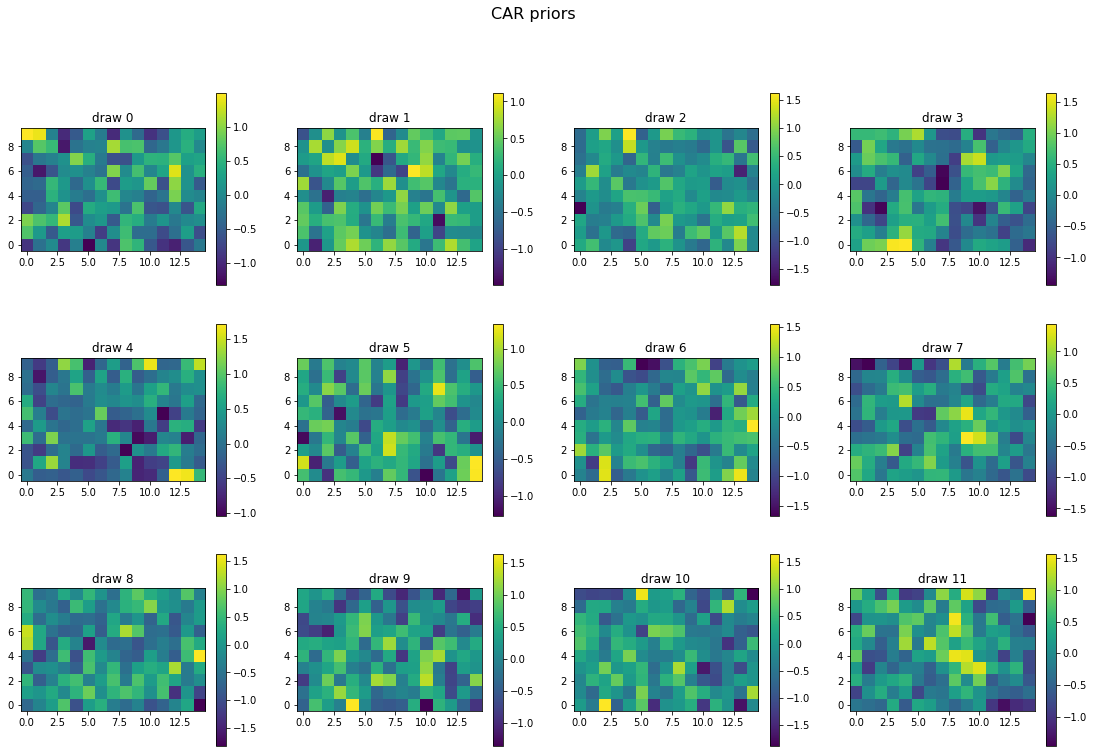

In [124]:
plot_samps(car_draws)

In [146]:
def get_car_draws_as_graph() -> jraph.GraphsTuple:
  G = nx.from_numpy_matrix(A)

  edges = list(G.edges)
  edges += [(edge[1], edge[0]) for edge in edges]
  senders = jnp.asarray([edge[0] for edge in edges])
  receivers = jnp.asarray([edge[1] for edge in edges])

  return jraph.GraphsTuple(
    n_node = jnp.asarray([len(G.nodes)]),
    n_edge = jnp.asarray([len(edges)]),
    nodes=car_draws.T, # (n_node, batch_size)
    edges=None,
    globals=None,
    senders=senders, 
    receivers=receivers)
  
graph = get_car_draws_as_graph()

In [148]:
train_graph = graph
train_senders = train_graph.senders
train_receivers = train_graph.receivers
train_labels = train_graph.nodes

In [151]:
num_nodes = train_graph.n_node.item()
feat_matrix_dim = train_graph.nodes.shape
assert num_nodes == feat_matrix_dim[0], 'num_nodes != feat_matrix_dim[0]'
assert feat_matrix_dim == train_labels.shape, 'feat_matrix_dim != train_labels.shape'
print('Number of nodes:', num_nodes)
print('Feature matrix dim (n_node x n_feat):', feat_matrix_dim)
print('Labels shape:', train_labels.shape)

Number of nodes: 150
Feature matrix dim (n_node x n_feat): (150, 100)
Labels shape: (150, 100)


In [324]:
from typing import NamedTuple

class Args(NamedTuple):
  hidden_dim: int 
  latent_dim: int
  output_dim: int
  learning_rate: float
  epochs: int
  eval_frequency : int

In [325]:
rng_key, params_key = jax.random.split(rng_key)

wargs = Args(
  hidden_dim=130, 
  latent_dim=130,
  learning_rate=1e-3,
  output_dim=train_labels.shape[1],
  epochs=300,
  eval_frequency=10,
)

# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=wargs.hidden_dim, 
                 latent_dim=wargs.latent_dim, 
                 output_dim=wargs.output_dim)(x))
optimizer = optax.adam(wargs.learning_rate)
params = net.init(params_key, train_graph)
opt_state = optimizer.init(params)

In [326]:
from model import VGAEOutput
from loss import compute_mse_loss, compute_kl_gaussian

@jax.jit
def loss_fn(params: hk.Params, 
            rng_key: jnp.ndarray,
            graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -compute_mse_loss(outputs.output.nodes, train_labels)
  kld = jnp.mean(compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  loss = log_likelihood - kld  # want to maximize this quantity.
  return -loss
  
@jax.jit
def update(
params: hk.Params,
rng_key: jnp.ndarray,
opt_state: optax.OptState,
graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [327]:
rng_seq_split_num = (wargs.epochs
                     + 2*(wargs.epochs/100 * wargs.eval_frequency)  # every eval_frequency, we use 2 keys.
                     + 2  # last epoch
                     + 1  # for rng_key
                    )
rng_key, *rng_seq = jax.random.split(rng_key, rng_seq_split_num)
rng_seq = iter(rng_seq)

for epoch in range(wargs.epochs):
    params, opt_state = update(params, next(rng_seq), opt_state, train_graph)
  
    if epoch % wargs.eval_frequency == 0 or epoch == (wargs.epochs - 1):
      train_loss = loss_fn(params, next(rng_seq), train_graph)
      train_output = net.apply(params, next(rng_seq), train_graph)
      print(f'epoch: {epoch}, train_loss: {train_loss:.5f}')

epoch: 0, train_loss: 10.02896
epoch: 10, train_loss: 2.37452
epoch: 20, train_loss: 1.48240
epoch: 30, train_loss: 1.03279
epoch: 40, train_loss: 0.81802
epoch: 50, train_loss: 0.70185
epoch: 60, train_loss: 0.62787
epoch: 70, train_loss: 0.58444
epoch: 80, train_loss: 0.54993
epoch: 90, train_loss: 0.52086
epoch: 100, train_loss: 0.50204
epoch: 110, train_loss: 0.48536
epoch: 120, train_loss: 0.47162
epoch: 130, train_loss: 0.46293
epoch: 140, train_loss: 0.45471
epoch: 150, train_loss: 0.44213
epoch: 160, train_loss: 0.43543
epoch: 170, train_loss: 0.42968
epoch: 180, train_loss: 0.42681
epoch: 190, train_loss: 0.41908
epoch: 200, train_loss: 0.41623
epoch: 210, train_loss: 0.41164
epoch: 220, train_loss: 0.40498
epoch: 230, train_loss: 0.40179
epoch: 240, train_loss: 0.40236
epoch: 250, train_loss: 0.39747
epoch: 260, train_loss: 0.39672
epoch: 270, train_loss: 0.39189
epoch: 280, train_loss: 0.39111
epoch: 290, train_loss: 0.38894
epoch: 299, train_loss: 0.39017


In [329]:
# f = lambda x: VGAE(hidden_dim=32, latent_dim=16, output_dim=train_labels.shape[1])(x)
# f = hk.transform(f)
# print(hk.experimental.tabulate(f)(train_graph))

In [330]:
decoder_params = {
  'hidden': params['vgae/hidden'],
  'output': params['vgae/output'],
}

In [341]:
from model import prior_decode
from functools import partial

decoder_net_fn = partial(prior_decode, hidden_dim=wargs.hidden_dim, output_dim=wargs.output_dim)
decoder_net = hk.transform(decoder_net_fn)

In [343]:
# from model import vgae_encoder

# enc_fn = partial(vgae_encoder, hidden_dim=32, latent_dim=16)
# enc = hk.transform(enc_fn)
# enc_params = enc.init(params_key, train_graph)
# mean_graph, log_std_graph = enc.apply(enc_params, rng_key, train_graph)

# mean, log_std = mean_graph.nodes, log_std_graph.nodes
# z = mean + jnp.exp(log_std) * jax.random.normal(rng_key, mean.shape)
# z.shape

In [354]:
z = jax.random.normal(rng_key, shape=(train_graph.n_node.item(), wargs.latent_dim))
z_graph = train_graph._replace(nodes=z)  # assumes no edge_feats

In [355]:
out_graph = decoder_net.apply(decoder_params, rng_key, z_graph)
vae_draws = out_graph.nodes
vae_draws = vae_draws.T  # change back to (batch_size, n_node)
assert vae_draws.shape == car_draws.shape

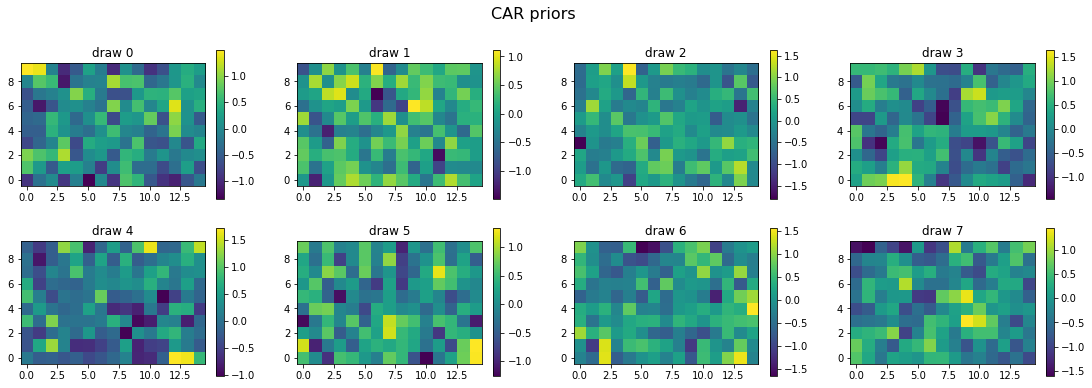

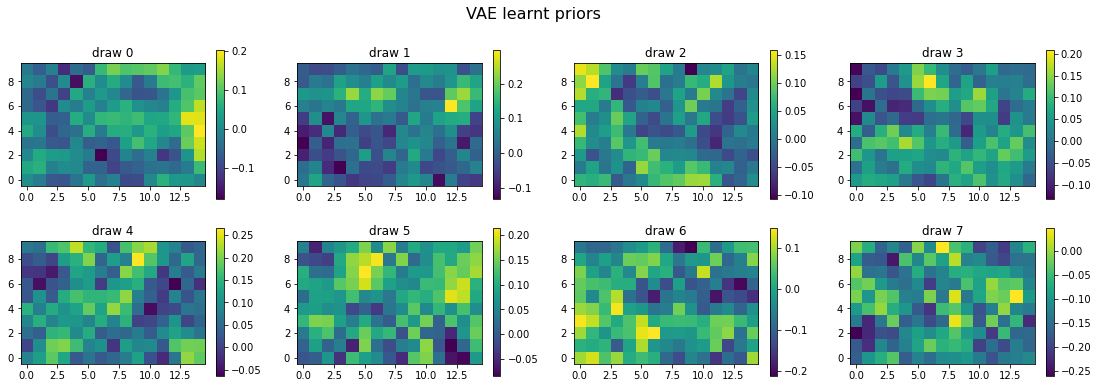

In [356]:
plot_samps(car_draws, rows=2, figsize=(19, 6))
plot_samps(vae_draws, rows=2, figsize=(19, 6), ttl='VAE learnt priors')